In [1]:
#necesarry imports
import csv
import pandas as pd
import numpy as np
import string
%matplotlib inline

import gensim
import os
import json
import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import sys

In [2]:
trackDF = pd.read_csv("labeled_lyrics_cleaned.csv") #read in our primary data source

In [3]:
auth = SpotifyClientCredentials(client_id= "b00d76d143704e85a7514c593e74e5c8", 
                                client_secret="819657134bef43ca8be863963090d73f")

urn = 'spotify:artist:3jOstUTkEu2JkjvRdBA5Gu'
sp = spotipy.Spotify(client_credentials_manager = auth)

def genreType(name): #only used if user decides to make own genre.json instead of downloading provided json
    results = sp.search(q='artist:' + name, type='artist')
    return results["artists"]["items"][0]["genres"]

In [4]:
if (os.path.exists("genre.json")): #if genre.json is downloaded and avaliable, use it
    with open('genre.json') as json_data:
        data = json.load(json_data)
else: #otherwise create own genre.json using Spotify API 
    artists = list(set(trackDF["artist"]))

    genreDict = {}
    for idx, art in enumerate(artists):
        sys.stdout.write(f"{idx +1} / {len(artists)}\n")
        try:
            genre = genreType(art)
            genreDict[art] = genre
        except IndexError:
            genreDict[art] = []  
    with open("genre.json", "w") as outfile:
        json.dump(genreDict, outfile)

In [5]:
#Cleaning data to be able to merge artist with genre
values = list(data.values())
keys = list(data.keys())
finalDict = {}
for i,v in enumerate(keys):
    finalDict[v] = [values[i]]
finalDict = pd.DataFrame(finalDict)
finalDict = finalDict.T

finalDict.columns = ['genre']
finalDict = finalDict.reset_index()
finalDict = finalDict.rename(columns = {"index": "artist"})

final = pd.merge(trackDF, finalDict, on = "artist", how = "left")

In [6]:
#helper methods to enable separating dataframes by genre
def rockCheck(genre):
    if "rock" in genre:
        return True
    else:
        return False
    
def popCheck(genre):
    if "pop" in genre:
        return True
    else:
        return False
    
def rapCheck(genre):
    if "rap" in genre:
        return True
    elif "r&b" in genre:
        return True
    else:
        return False
    
def countryCheck(genre):
    if "country" in genre:
        return True
    else:
        return False

In [7]:
#using helper methdods to create dataframes for each genre
final["rock"] = final.genre.apply(rockCheck)
rockDF = final[final["rock"] == True]

final["pop"] = final.genre.apply(popCheck)
popDF = final[final["pop"] == True]

final["rap"] = final.genre.apply(rapCheck)
rapDF = final[final["rap"] == True]

final["country"] = final.genre.apply(countryCheck)
countryDF = final[final["country"] == True]

In [17]:
countrySongs = countryDF.seq.apply(gensim.utils.simple_preprocess) #tokenizing and removing stop words for corpus

countryModel = gensim.models.Word2Vec( #model architecture
    window = 10,
    min_count = 2,
    workers = 2,
    sg = 1
    )

countryModel.build_vocab(countrySongs, progress_per = 1000)
countryModel.train(countrySongs, total_examples = countryModel.corpus_count, epochs = countryModel.epochs)

(5897685, 7987525)

In [9]:
rockSongs = rockDF.seq.apply(gensim.utils.simple_preprocess)

rockModel = gensim.models.Word2Vec(
    window = 10,
    min_count = 2,
    workers = 2,
    sg = 1
    )

rockModel.build_vocab(rockSongs, progress_per = 1000)
rockModel.train(rockSongs, total_examples = rockModel.corpus_count, epochs = rockModel.epochs)

18609


(13379529, 18153560)

In [10]:
popSongs = popDF.seq.apply(gensim.utils.simple_preprocess)

popModel = gensim.models.Word2Vec(
    window = 10,
    min_count = 2,
    workers = 2,
    sg = 1
    )

popModel.build_vocab(popSongs, progress_per = 1000)
popModel.train(popSongs, total_examples = popModel.corpus_count, epochs = popModel.epochs)

4891


(5029355, 7143005)

In [11]:
rapSongs = rapDF.seq.apply(gensim.utils.simple_preprocess)

rapModel = gensim.models.Word2Vec(
    window = 10,
    min_count = 2,
    workers = 2,
    sg = 1
    )

rapModel.build_vocab(rapSongs, progress_per = 1000)
rapModel.train(rapSongs, total_examples = rapModel.corpus_count, epochs = rapModel.epochs)

9115


(13825877, 18654550)

In [12]:
allSongs = final.seq.apply(gensim.utils.simple_preprocess)

allModel = gensim.models.Word2Vec(
    window = 10,
    min_count = 2,
    workers = 2,
    sg = 1
    )

allModel.build_vocab(allSongs, progress_per = 1000)
allModel.train(allSongs, total_examples = allModel.corpus_count, epochs = allModel.epochs)

158353


(122265531, 164501950)

In [18]:
#Using model to find similarities between words for different genres
word1 = "gay"
word2 = "hate"
models = [allModel, countryModel, rapModel, popModel, rockModel]
model_names = ["All Songs", "Country", "Rap", "Pop", "Rock"]
simDict = {}


for model, name in zip(models, model_names):
    simDict[name] = model.wv.similarity(w1 = word1, w2 = word2)

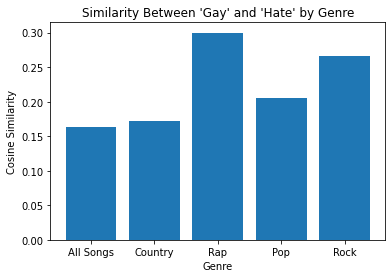

In [19]:
#Creation of graph
plt.bar(*zip(*simDict.items())) 
plt.title("Similarity Between \'Gay\' and \'Hate\' by Genre")
plt.xlabel('Genre')
plt.ylabel('Cosine Similarity')
#plt.savefig('Gay-Hate4.png')
plt.show()

In [15]:
#Using model to find 5 closest words in similarity to target word
word3 = "police"
similarities = []

for model, name in zip(models, model_names):
    similarities.append(name)
    similarities.append(model.wv.most_similar(word3, topn=5))
similarities

['All Songs',
 [('cops', 0.7425271272659302),
  ('coppers', 0.6914712190628052),
  ('officers', 0.6725534200668335),
  ('hakim', 0.6373288631439209),
  ('officer', 0.6367425322532654)],
 'Country',
 [('wham', 0.7868948578834534),
  ('milly', 0.7686740756034851),
  ('emergency', 0.7600117921829224),
  ('farmhouse', 0.7503462433815002),
  ('sheriff', 0.7434771060943604)],
 'Rap',
 [('badge', 0.7038032412528992),
  ('witout', 0.6822806000709534),
  ('cops', 0.6011911034584045),
  ('officer', 0.5982850790023804),
  ('monsters', 0.5866937637329102)],
 'Pop',
 [('popped', 0.7332776784896851),
  ('duck', 0.7328423857688904),
  ('dogs', 0.7269009947776794),
  ('offered', 0.7127363085746765),
  ('homies', 0.7087993025779724)],
 'Rock',
 [('cops', 0.6596987247467041),
  ('sloan', 0.5873602628707886),
  ('slammed', 0.5779464244842529),
  ('jables', 0.5770602822303772),
  ('workers', 0.5766988396644592)]]